In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2
import random
import torch
import numpy as np

from torchvision import models
from torchvision import transforms

from PIL import Image
from IPython.display import HTML

# MRCNN

In [20]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [21]:
maskrcnn = model
maskrcnn.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [22]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [23]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    
    # preprocess image
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0) # reshapes at 0 axis
    
    # make/ rank pred
    pred = maskrcnn(batch_t)
    
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    return img, pred, masks, pred_boxes, pred_class    

In [24]:
def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

In [27]:
def show_segmentations(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  img, pred, masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

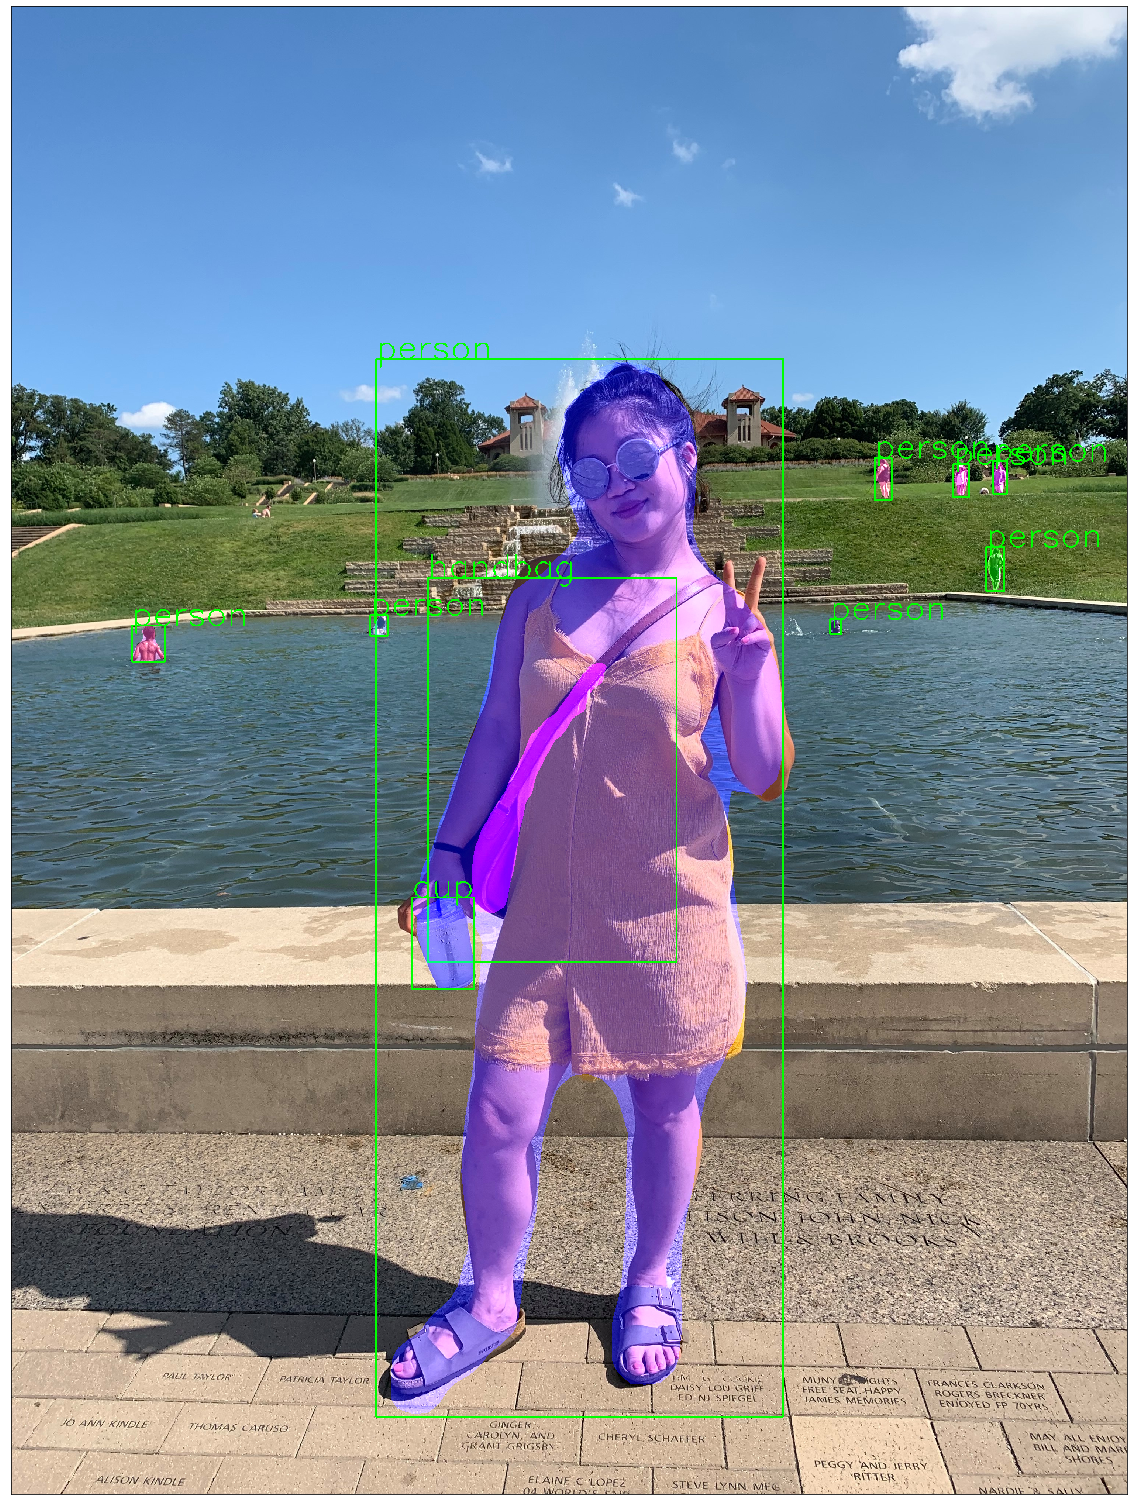

In [28]:
show_segmentations("imgs/tuby.jpg")

# Steps to do the thing
1. find the largest inst of something (with bb area)
    a. maybe narrow it to be person idk something we can try if we find that something is weird and funky
2.  only use that mask and run the create gif on it

In [30]:
def get_area(c1, c2):
    return abs(c2[0] - c1[0]) * abs(c2[1] - c1[1])

def largest_bb_area(pred_boxes):
    # ret index of the largest bounding box "fg"
    bbb = 0 #biggest bounding box lmao
    bbba = 0
    for idx, i in enumerate(pred_boxes):
#         print(i)
        curra = get_area(pred_boxes[idx][0], pred_boxes[idx][1])
        if curra > bbba:
            print(f"larger {idx}, {curra} than {bbb}, {bbba}")
            bbb = idx
            bbba = curra
    return bbb
    

In [31]:
pred_boxes

[[(989.60693, 956.8926), (2092.1384, 3822.989)],
 [(327.1695, 1678.2836), (417.63824, 1776.3993)],
 [(2642.0713, 1465.7346), (2691.3562, 1585.1274)],
 [(973.00934, 1650.2913), (1020.46655, 1706.2908)],
 [(1129.1699, 1549.918), (1803.8256, 2590.9734)],
 [(2340.4517, 1224.9058), (2386.0134, 1338.6027)],
 [(2553.731, 1241.3647), (2596.04, 1331.1307)],
 [(2660.7156, 1232.0442), (2699.2769, 1321.2394)],
 [(2219.985, 1661.6144), (2249.7637, 1702.9207)],
 [(1086.3478, 2415.1594), (1255.5574, 2664.7493)]]

In [34]:
def show_overlay(img, mask, bb=False):
  fig, axs = plt.subplots(1, figsize=(15,15))
  if type(bb) != bool:
    rect = pat.Rectangle( (bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth = 1, edgecolor= 'r', facecolor='none' )
    axs.add_patch(rect)

  masked = np.ma.masked_where(mask == 0, mask)
  plt.imshow(img, 'gray', interpolation='none')
  plt.imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)

def show_largest_seg(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    img, pred, masks, pred_boxes, pred_class = get_prediction(img_path, threshold)
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.array(img)
    idx = largest_bb_area(pred_boxes)
    box = pred_boxes[idx]
    mask = masks[idx]
    p_cls = pred_class[idx]

    show_overlay(img, mask, bb=box)

In [35]:
show_largest_seg("imgs/tuby.jpg")

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 1365590016 bytes. Error code 12 (Cannot allocate memory)


In [15]:
p_cls

'person'

In [14]:
# only pass largest
idx = largest_bb_area(pred_boxes)
box = pred_boxes[idx]
mask = masks[idx]
p_cls = pred_class[idx]

larger 0, 3159961.5 than 0, 0


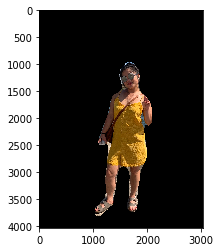

In [16]:
img = cv2.imread("imgs/tuby.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fg_mask = np.where(mask, 1, 0).astype('uint8')[:,:, np.newaxis]
bg_mask = np.where(mask, 0, 1).astype('uint8')[:,:, np.newaxis]

plt.figure 
plt.imshow(img * fg_mask)

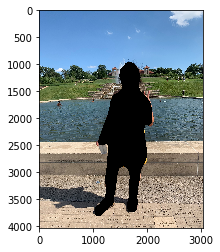

In [30]:
plt.imshow(img * bg_mask)

# Intro to ML Ends Here
## feel free to look, but this is for future use

In [31]:
def rough_mura_masa(img_path, mask, output_loc):
    
    img = cv2.imread(img_path)
#     img = cv2.cvtColor(img)
    
    fg_mask = np.where(mask, 1, 0).astype('uint8')[:,:, np.newaxis]
    bg_mask = np.where(mask, 0, 1).astype('uint8')[:,:, np.newaxis]
    
    fg_pxs = img * fg_mask
    bg_pxs = img * bg_mask

    for i in range(-10, 10):
        n = 5 * i
        move_n_x = np.roll(fg_pxs, shift=n, axis=1)
        new_img = np.where(move_n_x == 0, bg_pxs, move_n_x)
        cv2.imwrite(f"{output_loc}/img{i+10:02d}.jpg", new_img)

In [ ]:
rough_mura_masa("imgs/tuby.jpg", mask, "./mrcnn_res/tuby")


In [40]:
def gen_gif(img_path, gif_name, keep_mp4=False):
    mp4_gen = f"ffmpeg -pattern_type glob -i '{img_path}/*.jpg' {img_path}/test.mp4"
    pingpong_gen = f'ffmpeg -i {img_path}/test.mp4 -filter_complex "[0]reverse[r];[0][r]concat,loop=5:250,setpts=N/25/TB" {img_path}/output.mp4'
    gif_gen = f'ffmpeg -i {img_path}/output.mp4 -f gif {img_path}/{gif_name}.gif'
    output = f'rm {img_path}/output.mp4'
#     !{output}
    !{mp4_gen}
    !{pingpong_gen}
    !{gif_gen}
    
    if not keep_mp4:
        rm_mp4 = f'rm {img_path}/test.mp4'
        !{rm_mp4}

In [ ]:
gen_gif("./mrcnn_res/tuby", "mcrnn_tuby")

# enlarge the background

In [33]:
def rough_mura_masa_1(img_path, mask, output_loc):
    ret_img = []
    
    img = cv2.imread(img_path)
    
    fg_mask = np.where(mask, 1, 0).astype('uint8')[:,:, np.newaxis]
    bg_mask = np.where(mask, 0, 1).astype('uint8')[:,:, np.newaxis]
    
    fg_pxs = img * fg_mask
    bg_pxs = img * bg_mask
    
    w,h = fg_pxs.shape[1], fg_pxs.shape[0]
    dim = (int(w*1.5), int(h*1.5))
    
    # resize image
    resized = cv2.resize(fg_pxs, dim, interpolation = cv2.INTER_AREA)

    # crop the resize
    # middle of the picture, add the w and h on both sizes
    rw, rh = resized.shape[1], resized.shape[0]
    c1, c2= (rw//2 - w//2, rw//2 + w//2), (rh//2 - h//2, rh//2 + h//2)
    cropped = resized[c2[0]:c2[1],c1[0]:c1[1],:]
    plt.imshow(cropped)
    
    # infill a little to remove possible black px
    dst = cv2.inpaint(img, fg_mask, 1, cv2.INPAINT_NS )

    
    for i in range(-10, 10):
        n = 5 * i
        move_n_x = np.roll(cropped, shift=n, axis=1)
        new_img = np.where(move_n_x == 0, dst, move_n_x)
        ret_img.append(new_img)
        cv2.imwrite(f"{output_loc}/img{i+10:02d}.jpg", new_img)
   
    return ret_img

In [49]:
def rough_mura_masa_2(img_path, mask, output_loc):
    
    img = cv2.imread(img_path)
    
    fg_mask = np.where(mask, 1, 0).astype('uint8')[:,:, np.newaxis]
    bg_mask = np.where(mask, 0, 1).astype('uint8')[:,:, np.newaxis]
    
    fg_pxs = img * fg_mask
    bg_pxs = img * bg_mask
    
    w,h = fg_pxs.shape[1], fg_pxs.shape[0]
    dim_fg = (int(w*1.5), int(h*1.5))
    
    # resize image
    resized = cv2.resize(fg_pxs, dim_fg, interpolation = cv2.INTER_AREA)

    # crop the resize
    # middle of the picture, add the w and h on both sizes
    rw, rh = resized.shape[1], resized.shape[0]
    c1, c2= (rw//2 - w//2, rw//2 + w//2), (rh//2 - h//2, rh//2 + h//2)
    cropped = resized[c2[0]:c2[1],c1[0]:c1[1],:]
#     plt.imshow(cropped)
    
    # infill a little to remove possible black px
    infill_fg = cv2.inpaint(img, fg_mask, 1, cv2.INPAINT_NS )

    # move the bk by larging a bit and shifting pixs
    dim_bg = (int(w*1.1), int(h*1.1))
    resized_bg = cv2.resize(infill_fg, dim_bg, interpolation = cv2.INTER_AREA)

    
    for i in range(-5, 5):
        n = 3 * i
        move_n_x = np.roll(cropped, shift=n, axis=1)
        move_n_bg = np.roll(resized_bg, shift=-n, axis=1)
        
        rw, rh = resized_bg.shape[1], resized_bg.shape[0]
        c1, c2= (rw//2 - w//2, rw//2 + w//2), (rh//2 - h//2, rh//2 + h//2)
        cropped_bg = move_n_bg[c2[0]:c2[1],c1[0]:c1[1],:]
        
        print(cropped_bg.shape)
        plt.imshow(cropped_bg)
        
        new_img = np.where(move_n_x == 0, cropped_bg, move_n_x)
        cv2.imwrite(f"{output_loc}/img{i+10:02d}.jpg", new_img)


(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)


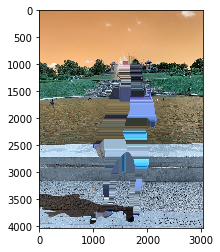

In [50]:
rough_mura_masa_2("imgs/tuby.jpg", mask, "./mrcnn_res/tuby_mv_bk")

In [51]:
gen_gif("./mrcnn_res/tuby_mv_bk", "mcrnn_tuby")

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

frame=  120 fps=9.5 q=-1.0 Lsize=    6718kB time=00:00:04.68 bitrate=11758.4kbits/s speed=0.37x     
video:6715kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.034422%
[libx264 @ 0x557447620660] frame I:1     Avg QP:18.20  size:2040445
[libx264 @ 0x557447620660] frame P:35    Avg QP:20.66  size: 78724
[libx264 @ 0x557447620660] frame B:84    Avg QP:27.16  size: 24761
[libx264 @ 0x557447620660] consecutive B-frames:  0.8% 16.7%  2.5% 80.0%
[libx264 @ 0x557447620660] mb I  I16..4:  7.8% 75.2% 17.0%
[libx264 @ 0x557447620660] mb P  I16..4:  0.3%  1.1%  0.1%  P16..4: 18.0%  2.0%  1.5%  0.0%  0.0%    skip:76.9%
[libx264 @ 0x557447620660] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8: 16.9%  0.6%  0.2%  direct: 0.9%  skip:81.4%  L0:47.9% L1:51.5% BI: 0.6%
[libx264 @ 0x557447620660] 8x8 transform intra:73.0% inter:72.7%
[libx264 @ 0x557447620660] coded y,uvDC,uvAC intra: 59.4% 42.8% 19.1% inter: 1.0% 6.8% 5.0%
[libx264 @ 0x557447620660] i16 v,h,dc,p: 20% 51% 11% 18%